In [1]:
%%time
#    This file is part of Multi-objective optimization under uncertainty research

import array, copy, random
# import logging
# import random
import numpy as np

# imports for the BNN
import torch
import torch.nn as nn
import torch.nn.functional as F

import keras
from keras import backend as K

import pickle

from deap import algorithms, base, creator, tools

# # set GPU device to device_num
# device_num = 1
# torch.cuda.set_device(device_num)
# print(torch.cuda.current_device())

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda3\envs\deep-learning\lib\site-packages\tensorflo

Wall time: 2.56 s


In [2]:
# load min and max values of the data to denormalize prediction data
with open('maxmin.pickle', 'rb') as f:
    [max_x, min_x, max_y, min_y] = pickle.load(f)
    
# load min and max values of the data to denormalize prediction data
with open('maxmin_thickness.pickle', 'rb') as f:
    [X_max, X_min, Y_max, Y_min] = pickle.load(f)    

def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

class KerasDropoutPrediction(object):
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
        
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
        result = np.array(result).reshape(n_iter,len(x)).T
        return result
    
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x

    
# load BL model BNN and evaluate objectives
model_BL = torch.load('BNN_BLmodel.pt')

# load the thickness model
model_thickness = keras.models.load_model('MCdropout_model_thickness.h5', compile=False)

# predict with dropout
kdp = KerasDropoutPrediction(model_thickness)


def evaluate(vars):
    
#     # load BL model BNN
#     BL_model = torch.load('BNN_BLmodel.pt')

    # Minimize(abs(pred_mean – target))
    target  = 4.2 # desired part thickness in mm

    # number of total layers = (maximum part height)/(height of a layer), i.e., 4.2 / (layer height)
    if vars[2] == 1:
        height = 0.42
    elif vars[2] == 2:
        height = 0.6
    elif vars[2] == 3:
        height = 0.7

    # print(vars)
    num_layers = np.int(target / height); # number of layers

    num_interfaces = 14     # number of interfaces per layer
    width = 0.8             # filament width in mm

    ycoord = 0.5 * height  # 0.5*height of a layer in mm
    iki_y = ycoord * 2
    
    # Create an input array to predict overall part thickness
    inp_BL = [] # input to BNN to make predictions
    
    # store inputs for GP(model disrepancy at each interface)
    for jj in range(1, num_layers + 1):
        for ii in range(1, num_interfaces + 1):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y ]
            inp_BL.append([vars[0], vars[1], height, ii * width, ycoord + (jj - 1) * iki_y])

    # Convert built Python lists to a Numpy array.
    inp_BL = np.array(inp_BL, dtype='float32')

    # normalize data
    inp_BL = normalize_max_min(inp_BL, max_x, min_x)

    x_pred = torch.tensor(inp_BL)  # convert to torch tensor

    samples = []
    noises = []
    for i in range(10):
        preds = model_BL.forward(x_pred).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5


    # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
    dimensionless_mean_bl = means.mean()/height
    dimensionless_total_unc_bl = total_unc.mean()/height**2

    
#     # load the thickness model
#     model_thickness = keras.models.load_model('MCdropout_model_thickness.h5', compile=False)

#     # predict with dropout
#     kdp = KerasDropoutPrediction(model_thickness)

    x_pos = 7 # mm
    num_iter = (10.5-1.5)/0.01 + 1
        
     # Create an input array to predict overall part thickness
    inp_thickness = []
    
    # store inputs for GP(model disrepancy at each interface)
    for jj in range(5):

        y_pos = 1.5 # mm

        for ii in range(int(num_iter)):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y]
            inp_thickness.append([vars[0], vars[1], height, x_pos, y_pos])
            
            y_pos += 0.01 # increment y position 0.01 mm

        x_pos += 5 # x coordinate  
    
    # Convert built Python lists to a Numpy array.
    inp_thickness = np.array(inp_thickness, dtype='float32')

    # normalize data
    inp_thickness = normalize_max_min(inp_thickness, X_max, X_min)
    
    # Predict
    y_pred_do = kdp.predict(inp_thickness,n_iter=10)
    y_pred_do_org = denormalize_max_min(y_pred_do, Y_max, Y_min)
    y_pred_do_org_mean = y_pred_do_org.mean(axis=1).reshape(-1, 1)
    y_pred_do_org_std = y_pred_do_org.std(axis=1).reshape(-1, 1)
    
    # Predicted mean and std part thicknesses
    mean_part_thickness = y_pred_do_org_mean.mean()
    std_part_thickness = ((y_pred_do_org_std**2).mean())**0.5
    
    return 1-dimensionless_mean_bl, abs(mean_part_thickness-target)



# The constraint is:
# (Nozzle velocity) x (line width) x (layer thickness)  less than/ equal to 24 mm/s3
def feasible(individual):
    """Feasability function for the individual. Returns True if feasible False
    otherwise."""
    
    line_width = 0.8 # in mm
    
    # layer height in mm
    if individual[2] == 1:
        height = 0.42
    elif individual[2] == 2:
        height = 0.6
    elif individual[2] == 3:
        height = 0.7
        
    if individual[1] * line_width * height <= 24:
#         print(individual,'true')
        return True
#     print(individual,'false')
    return False

IND_SIZE = 3
N_CYCLES = 1
BOUND_LOW, BOUND_UP = [217, 26, 1], [278, 44, 3]

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin, n=IND_SIZE)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_temperature", random.randint, 217, 278)
toolbox.register("attr_speed", random.randint, 26, 44)
toolbox.register("attr_layer", random.randint, 1, 3)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_temperature,toolbox.attr_speed,toolbox.attr_layer), n=N_CYCLES)

# Structure initializers
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# load BL model BNN and evaluate objectives
# toolbox.model1 = torch.load('BNN_BLmodel.pt')
toolbox.register("evaluate", evaluate)

# # load the thickness model
# model_thickness = keras.models.load_model('MCdropout_model_thickness.h5', compile=False)

# # predict with dropout
# toolbox.model2 = KerasDropoutPrediction(model_thickness)

# A penality function can be added to any evaluation function using the DeltaPenality decorator provided in the tools module.
# Delta = [0,1] worst cases
toolbox.decorate("evaluate", tools.DeltaPenality(feasible, [1,1]))

toolbox.register("mate", tools.cxUniform, indpb=0.50)
toolbox.register("mutate", tools.mutUniformInt, low=BOUND_LOW, up=BOUND_UP, indpb=0.50)

def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max[i]:
#                         print(child[i])
                        child[i] = max[i]
                    elif child[i] < min[i]:
#                         print(child[i])
                        child[i] = min[i]
            return offspring
        return wrappper
    return decorator

# Bounds on the design variables
toolbox.decorate("mate", checkBounds([217, 26, 1], [278, 44, 3]))
toolbox.decorate("mutate", checkBounds([217, 26, 1], [278, 44, 3]))

toolbox.register("select", tools.selNSGA2)
# ref_points = tools.uniform_reference_points(nobj=2, p=12)
# toolbox.register("select", tools.selNSGA3WithMemory(ref_points))

# toolbox.pop_size = 100
# toolbox.max_gen = 10
toolbox.mut_prob = 0.2

# def main(toolbox):
#     random.seed(64)

#     pop = toolbox.population(n=toolbox.pop_size)
#     hof = tools.ParetoFront()
#     stats = tools.Statistics(lambda ind: ind.fitness.values)
#     stats.register("avg", np.mean, axis=0)
#     stats.register("std", np.std, axis=0)
#     stats.register("min", np.min, axis=0)
#     stats.register("max", np.max, axis=0)

#     algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, lambda_=toolbox.pop_size,
#                               cxpb=1-toolbox.mut_prob, mutpb=toolbox.mut_prob, ngen=toolbox.max_gen,
#                               stats=stats, halloffame=hof, verbose=True)

#     return pop, stats, hof

# if __name__ == "__main__":
#     pop, stats, hof = main(toolbox)

#     import matplotlib.pyplot as plt
#     import numpy

#     front = numpy.array([ind.fitness.values for ind in pop])
#     plt.scatter(front[:,0], front[:,1], c="b")
#     plt.axis("tight")
#     plt.xlabel("Dimensionless Mean Bond Length")
#     plt.ylabel("Absolute Error of Mean Part Thickness")
#     plt.show()
    
# stats = tools.Statistics()
# stats.register("pop", copy.deepcopy)

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\anaconda3\envs\deep-learning\lib\site-packages\torch\serialization.py:419: UserWarning: Couldn't retrieve source code for container of type MC_Dropout_Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
C:\anaconda3\envs\deep-learning\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\anaconda3\envs\deep-learning\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes

In [3]:
# ### import file from another folder ###
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '../Python-Save-Plots')
# import save_plots as sP
# # import SaveFigAsPDF_PGF as sF

In [4]:
# front = np.array([ind.fitness.values for ind in pop])
    
# x1, y1 = front[:,0], front[:,1]

# # row: number of lines, col.: dimension of the plot (e.g., (1,2) -> 1 line with x and y values)
# num_lines = 1
# dim_plot = 2

# # initialize array with size number of lines
# data = np.full((num_lines,dim_plot), None)
# data[0] = [x1,y1]

# sP.run_subplot(data, labels, filename, plot_type=2)

# Design of experiment

Find the optimal optimization parameters

In [5]:
experiment_name = "$n_\mathrm{{pop}}={0};\ n_\mathrm{{gen}}={1}$"

In [6]:
pop_sizes = (200,200,200)       # population size
gen_sizes = (10,20,30)       # generation size
# total_evals = 1000          # total num. of evaluations
number_of_runs = 30

In [7]:
# replicate this toolbox instance
toolboxes=list([copy.deepcopy(toolbox) for _ in range(len(pop_sizes))])

In [14]:
# set the population sizes in the elements of toolboxes
for pop_size, gen_size, toolbox in zip(pop_sizes, gen_sizes, toolboxes):
    toolbox.pop_size = pop_size
#     toolbox.max_gen = total_evals // pop_size
    toolbox.max_gen = gen_size
    toolbox.experiment_name = experiment_name.format(toolbox.pop_size, toolbox.max_gen)

In [15]:
# def run_algo_wrapper(toolbox):
#     result, _ = run_ea(toolbox)
#     local_pareto_set = tools.emo.sortLogNondominated(result, len(result), first_front_only=True)
#     return local_pareto_set

In [16]:
# %%time
# import concurrent.futures
# # progress_bar = IntProgress(description="000/000", max=len(toolboxes)*number_of_runs)
# # display(progress_bar)

# def main():
#     results = {toolbox.experiment_name:[] for toolbox in toolboxes}
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         # Submit all the tasks...
#         futures = {executor.submit(run_algo_wrapper, toolbox): toolbox
#                    for _ in range(number_of_runs)
#                    for toolbox in toolboxes}

#         # ...and wait for them to finish.
#         for future in concurrent.futures.as_completed(futures):
#             tb = futures[future]
# #             print(tb)
#             results[tb.experiment_name].append(future.result())
#     #         progress_bar.value +=1
#     #         progress_bar.description = "%03d/%03d:" % (progress_bar.value, progress_bar.max)

# if __name__ == '__main__':
#     main()

In [17]:
%%time
results = {toolbox.experiment_name:[] for toolbox in toolboxes}

for _ in range(number_of_runs):
    print('number of run:', _)
    for toolbox in toolboxes:
        result, _ = run_ea(toolbox)
        local_pareto_set = tools.emo.sortLogNondominated(result, len(result), first_front_only=True)
        results[toolbox.experiment_name].append(local_pareto_set)

number of run: 0
number of run: 1
number of run: 2
number of run: 3
number of run: 4
number of run: 5
number of run: 6
number of run: 7
number of run: 8
number of run: 9
number of run: 10
number of run: 11
number of run: 12
number of run: 13
number of run: 14
number of run: 15
number of run: 16
number of run: 17
number of run: 18
number of run: 19
number of run: 20
number of run: 21
number of run: 22
number of run: 23
number of run: 24
number of run: 25
number of run: 26
number of run: 27
number of run: 28
number of run: 29
Wall time: 2h 43min 58s


In [18]:
import pandas as pd
res = pd.DataFrame(results)
res.head()

,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=10$,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=20$,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=30$
0,"[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217....","[[218.0, 26.0, 1.0], [218.0, 26.0, 1.0], [218...."
1,"[[222.0, 26.0, 1.0], [222.0, 26.0, 1.0], [220....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217...."
2,"[[222.0, 26.0, 1.0], [272.0, 33.0, 1.0], [265....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217...."
3,"[[218.0, 26.0, 1.0], [218.0, 26.0, 1.0], [218....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217...."
4,"[[217.0, 26.0, 1.0], [217.0, 28.0, 1.0], [217....","[[217.0, 26.0, 1.0], [217.0, 28.0, 1.0], [217....","[[217.0, 26.0, 1.0], [217.0, 26.0, 1.0], [217...."


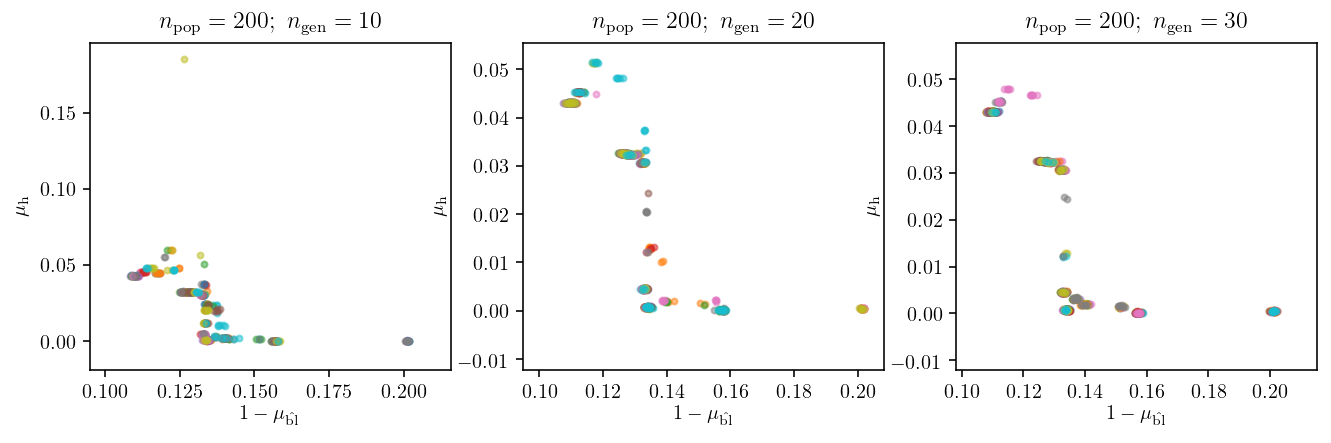

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)

a = res.applymap(lambda pop: [toolbox.evaluate(ind) for ind in pop])
fig = plt.figure(figsize=(11,3))
for i, col in enumerate(a.columns):
    plt.subplot(1, len(a.columns), i+1)
    for pop in a[col]:
        x = pd.DataFrame(data=pop)
        plt.scatter(x[0], x[1], marker='.', alpha=0.5)
    plt.title(col)
    plt.xlabel('$1-\mu_{\mathrm{\hat{bl}}}$')
    plt.ylabel('$\mu_{\mathrm{\th}}$')
    
filename = 'Pareto_front_exp_design'
fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)  

## Hypervolume computation

Sort the best individuals in each local Pareto optimal sets and add a vector (2D; each dimension for each objectives respectively) to obtain the reference point (nadir), worst case.

In [20]:
import deap.benchmarks.tools as bt

# Reference point
# reference = np.max([np.max([ind.fitness.values for ind in front], axis=0) for front in fronts], axis=0) + [-0.4, 0.1]

def calculate_reference(results, epsilon=[0.3,0.1]):
    alldata = np.concatenate(np.concatenate(results.values))
    obj_vals = [toolbox.evaluate(ind) for ind in alldata]
    return np.max(obj_vals, axis=0) + epsilon

reference = calculate_reference(res)

hypervols = res.applymap(lambda pop: bt.hypervolume(pop, reference))
hypervols.head()

,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=10$,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=20$,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=30$
0,0.111308,0.111515,0.110677
1,0.107723,0.111304,0.111578
2,0.107651,0.111495,0.111531
3,0.110230,0.111445,0.111535
4,0.111065,0.111481,0.111370


In [21]:
hypervols.describe()

,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=10$,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=20$,$n_\mathrm{pop}=200;\ n_\mathrm{gen}=30$
count,30.000000,30.000000,30.000000
mean,0.110229,0.111080,0.111375
std,0.001150,0.000584,0.000329
min,0.107452,0.109265,0.110186
25%,0.109971,0.110800,0.111374
50%,0.110617,0.111347,0.111448
75%,0.111095,0.111490,0.111554
max,0.111495,0.111565,0.111781


In [22]:
reference

array([0.50256216, 0.28493175])

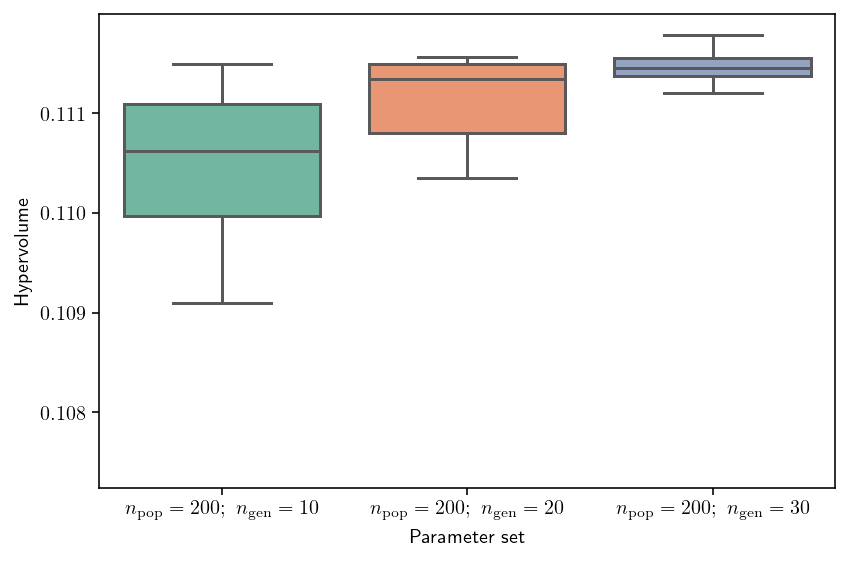

In [49]:
import seaborn

fig = plt.figure(figsize=(6,4))
# plt.subplot(121, title='Violin plots of NSGA-II with $P_{\mathrm{mut}}$')
# seaborn.violinplot(data=hypervols, palette='Set2')
# plt.ylabel('Hypervolume'); plt.xlabel('Configuration')
# plt.subplot(122,title='Box plots of NSGA-II with $P_{\mathrm{mut}}$')
# plt.subplot(title='Box plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.boxplot(data=hypervols, palette='Set2',whis=1.5,fliersize=0)
plt.ylabel('Hypervolume'); plt.xlabel('Parameter set');
plt.tight_layout()

In [50]:
filename = 'Hypervolume_exp_design'
fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)